# 第7章：批归一化（Batch Normalization）与 Dropout

## 学习目标

通过本章学习，你将能够：

1. **理解内部协变量偏移问题**：深度网络训练困难的根本原因
2. **掌握 Batch Normalization**：从零实现前向传播和反向传播
3. **掌握 Dropout**：理解正则化原理并完整实现
4. **构建现代神经网络**：完整的 64→128→128→10 网络，包含训练循环
5. **理解 Layer Normalization**：与 BN 的区别和应用场景

In [5]:
# ========================================
# 导入必要的库
# ========================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'STHeiti']
plt.rcParams['axes.unicode_minus'] = False

# 设置随机种子，确保结果可复现
np.random.seed(42)

print("环境设置完成！")

环境设置完成！


## 术语说明：Dense 层（全连接层）

在深度学习框架中，**Dense** 是全连接层（Fully Connected Layer）的常用名称：

| 框架/库 | 名称 | 说明 |
|---------|------|------|
| Keras/TensorFlow | `Dense` | 最常用的名称 |
| PyTorch | `Linear` | 强调线性变换 |
| NumPy（本教程） | `z = X @ W + b` | 手动实现 |

**数学本质完全相同**：
```
output = input @ W + b
```

本章网络架构：
```
输入(64) → Dense(128) → BN → ReLU → Dropout →
           Dense(128) → BN → ReLU → Dropout →
           Dense(10) → Softmax → 输出
```

---
# 第一部分：理论基础

## 为什么需要 Batch Normalization 和 Dropout？

### 深度网络训练的两大挑战

**问题1：内部协变量偏移（Internal Covariate Shift）**
- 随着训练进行，每层的输入分布不断变化
- 后面的层需要不断适应新的分布
- 导致训练缓慢、需要小学习率

**问题2：过拟合（Overfitting）**
- 网络容量过大时容易记住训练数据
- 在测试集上表现差
- 需要正则化技术

### 解决方案

| 问题 | 解决方案 | 原理 |
|------|----------|------|
| 内部协变量偏移 | Batch Normalization | 标准化每层输入 |
| 过拟合 | Dropout | 随机丢弃神经元 |

---
# 第二部分：Batch Normalization

## 2.1 BN 的数学原理

### 前向传播公式

对于输入 $X$（shape: `[batch_size, n_features]`）：

1. **计算批次均值**：$\mu = \frac{1}{m} \sum_{i=1}^{m} x_i$

2. **计算批次方差**：$\sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu)^2$

3. **标准化**：$\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}$

4. **缩放和平移**：$y_i = \gamma \hat{x}_i + \beta$

其中：
- $\epsilon$ 是防止除零的小常数（通常 1e-5）
- $\gamma$ 和 $\beta$ 是可学习参数，通过反向传播更新

### 反向传播公式

给定上游梯度 $\frac{\partial L}{\partial y}$，需要计算：

1. **对 $\gamma$ 的梯度**：$\frac{\partial L}{\partial \gamma} = \sum_{i} \frac{\partial L}{\partial y_i} \cdot \hat{x}_i$

2. **对 $\beta$ 的梯度**：$\frac{\partial L}{\partial \beta} = \sum_{i} \frac{\partial L}{\partial y_i}$

3. **对输入 $x$ 的梯度**：（较复杂，有三条路径）

In [6]:
# ========================================
# BatchNormalization 完整实现
# ========================================

class BatchNormalization:
    """
    批归一化层的完整实现，包含前向传播和反向传播
    
    参数说明：
        n_features: 输入特征数量
        momentum: 移动平均的动量系数，用于推理时的统计量
        epsilon: 防止除零的小常数
    
    可学习参数：
        gamma: 缩放参数，初始化为 1
        beta: 平移参数，初始化为 0
    """
    
    def __init__(self, n_features, momentum=0.9, epsilon=1e-5):
        # ===== 可学习参数（通过反向传播更新）=====
        self.gamma = np.ones(n_features)   # 缩放参数，shape: (n_features,)
        self.beta = np.zeros(n_features)   # 平移参数，shape: (n_features,)
        
        # ===== 推理时使用的移动平均统计量 =====
        self.running_mean = np.zeros(n_features)  # 累积均值
        self.running_var = np.ones(n_features)    # 累积方差
        
        # ===== 超参数 =====
        self.momentum = momentum
        self.epsilon = epsilon
        
        # ===== 缓存（用于反向传播）=====
        self.cache = None
        
        # ===== 梯度 =====
        self.grad_gamma = None
        self.grad_beta = None
    
    def forward(self, X, training=True):
        """
        前向传播
        
        参数：
            X: 输入数据，shape (batch_size, n_features)
            training: True 使用批次统计，False 使用移动平均统计
        
        返回：
            归一化后的输出，shape (batch_size, n_features)
        """
        if training:
            # ===== 训练模式 =====
            
            # Step 1: 计算当前批次的均值和方差
            batch_mean = np.mean(X, axis=0)  # shape: (n_features,)
            batch_var = np.var(X, axis=0)    # shape: (n_features,)
            
            # Step 2: 标准化
            X_centered = X - batch_mean
            std_inv = 1.0 / np.sqrt(batch_var + self.epsilon)
            X_normalized = X_centered * std_inv
            
            # Step 3: 缩放和平移
            out = self.gamma * X_normalized + self.beta
            
            # Step 4: 更新移动平均统计量
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * batch_mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * batch_var
            
            # Step 5: 缓存中间变量
            self.cache = {
                'X': X, 'X_centered': X_centered, 'X_normalized': X_normalized,
                'std_inv': std_inv, 'batch_var': batch_var
            }
        else:
            # ===== 推理模式 =====
            X_normalized = (X - self.running_mean) / np.sqrt(self.running_var + self.epsilon)
            out = self.gamma * X_normalized + self.beta
        
        return out
    
    def backward(self, dout):
        """
        反向传播
        
        参数：
            dout: 上游梯度，shape (batch_size, n_features)
        
        返回：
            dX: 对输入的梯度，shape (batch_size, n_features)
        """
        X = self.cache['X']
        X_centered = self.cache['X_centered']
        X_normalized = self.cache['X_normalized']
        std_inv = self.cache['std_inv']
        batch_var = self.cache['batch_var']
        m = X.shape[0]
        
        # Step 1: 对 gamma 和 beta 的梯度
        self.grad_gamma = np.sum(dout * X_normalized, axis=0)
        self.grad_beta = np.sum(dout, axis=0)
        
        # Step 2: 对 X_normalized 的梯度
        dX_normalized = dout * self.gamma
        
        # Step 3: 对方差的梯度
        dvar = np.sum(dX_normalized * X_centered * (-0.5) * (batch_var + self.epsilon)**(-1.5), axis=0)
        
        # Step 4: 对均值的梯度
        dmean = np.sum(dX_normalized * (-std_inv), axis=0) + dvar * np.sum(-2 * X_centered, axis=0) / m
        
        # Step 5: 对输入 X 的梯度
        dX = dX_normalized * std_inv + dvar * 2 * X_centered / m + dmean / m
        
        return dX

# 测试 BatchNormalization
print("测试 BatchNormalization:")
bn = BatchNormalization(n_features=4)
X_test = np.random.randn(3, 4) * 5 + 10
print(f"输入均值: {X_test.mean(axis=0).round(2)}")
print(f"输入标准差: {X_test.std(axis=0).round(2)}")

out = bn.forward(X_test, training=True)
print(f"BN后均值: {out.mean(axis=0).round(4)}")
print(f"BN后标准差: {out.std(axis=0).round(4)}")
print("标准化成功：均值接近0，标准差接近1")

测试 BatchNormalization:
输入均值: [ 9.66 10.28 12.94 13.04]
输入标准差: [2.06 1.73 4.17 4.1 ]
BN后均值: [ 0.  0. -0.  0.]
BN后标准差: [1. 1. 1. 1.]
标准化成功：均值接近0，标准差接近1


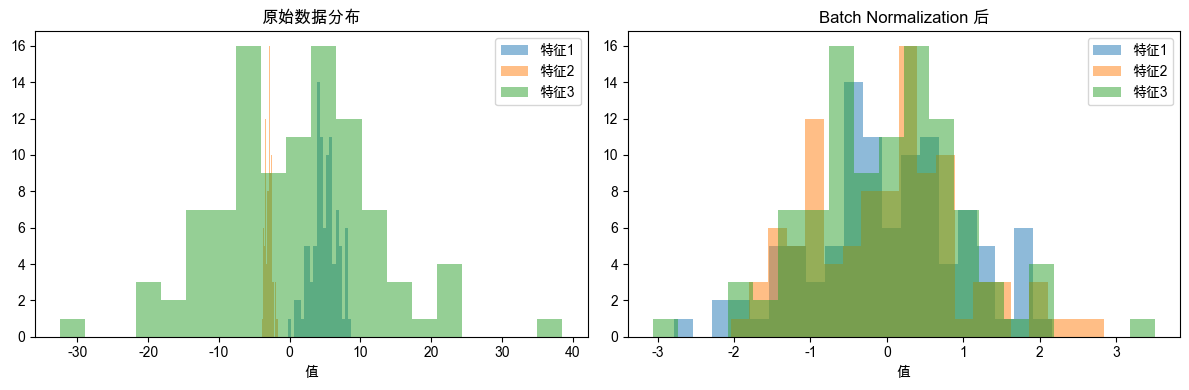

In [7]:
# ========================================
# 可视化 BN 对数据分布的影响
# ========================================

np.random.seed(42)
X_varied = np.column_stack([
    np.random.randn(100) * 2 + 5,
    np.random.randn(100) * 0.5 - 3,
    np.random.randn(100) * 10 + 0,
])

bn_vis = BatchNormalization(n_features=3)
X_normalized = bn_vis.forward(X_varied, training=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax1 = axes[0]
for i in range(3):
    ax1.hist(X_varied[:, i], bins=20, alpha=0.5, label=f'特征{i+1}')
ax1.set_title('原始数据分布')
ax1.set_xlabel('值')
ax1.legend()

ax2 = axes[1]
for i in range(3):
    ax2.hist(X_normalized[:, i], bins=20, alpha=0.5, label=f'特征{i+1}')
ax2.set_title('Batch Normalization 后')
ax2.set_xlabel('值')
ax2.legend()

plt.tight_layout()
plt.show()

---
# 第三部分：Dropout

## 3.1 Dropout 原理

### 核心思想
- **训练时**：随机"丢弃"（置零）一部分神经元
- **推理时**：使用全部神经元

### Inverted Dropout（推荐实现）
- 训练时：丢弃后缩放，保持期望值不变
- 推理时：不需要额外处理

### 数学公式

设丢弃概率为 $p$，则：

**训练时**：$y = \frac{x \cdot mask}{1 - p}$

**推理时**：$y = x$

In [8]:
# ========================================
# Dropout 完整实现
# ========================================

class Dropout:
    """
    Dropout 层（Inverted Dropout）
    
    参数：
        p: 丢弃概率（0-1），默认0.5
    """
    
    def __init__(self, p=0.5):
        self.p = p
        self.mask = None
    
    def forward(self, X, training=True):
        if training:
            # 训练模式：随机丢弃并缩放
            self.mask = (np.random.rand(*X.shape) > self.p).astype(np.float64)
            out = X * self.mask / (1 - self.p)
        else:
            # 推理模式：直接返回
            out = X
            self.mask = np.ones_like(X)
        return out
    
    def backward(self, dout):
        # 梯度只通过保留的神经元
        return dout * self.mask / (1 - self.p)

# 测试
print("测试 Dropout (p=0.5):")
dropout = Dropout(p=0.5)
X_test = np.ones((3, 6))
print(f"输入:\n{X_test}")
out = dropout.forward(X_test, training=True)
print(f"输出:\n{out}")
print("保留的值被放大为2，丢弃的值为0")

测试 Dropout (p=0.5):
输入:
[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
输出:
[[0. 0. 2. 2. 2. 0.]
 [0. 2. 0. 2. 2. 0.]
 [2. 2. 0. 2. 2. 2.]]
保留的值被放大为2，丢弃的值为0


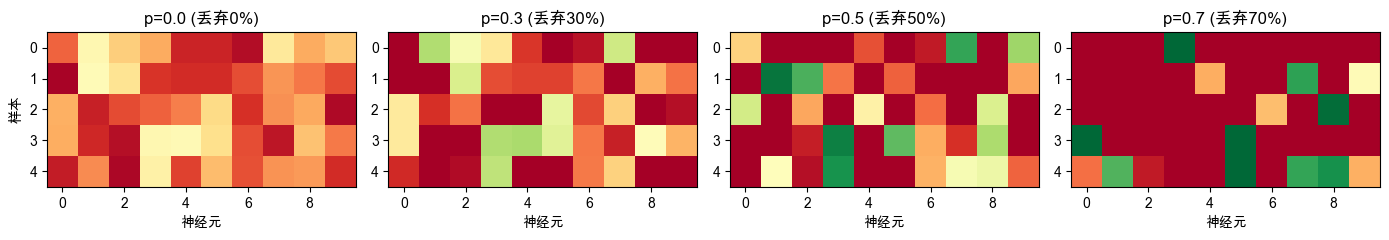

In [9]:
# ========================================
# 可视化 Dropout 效果
# ========================================

np.random.seed(42)
X_neurons = np.random.rand(5, 10)
dropout_rates = [0.0, 0.3, 0.5, 0.7]

fig, axes = plt.subplots(1, 4, figsize=(14, 3))

for idx, p in enumerate(dropout_rates):
    dropout = Dropout(p=p)
    out = dropout.forward(X_neurons.copy(), training=True)
    ax = axes[idx]
    ax.imshow(out, cmap='RdYlGn', vmin=0, vmax=2)
    ax.set_title(f'p={p} (丢弃{int(p*100)}%)')
    ax.set_xlabel('神经元')
    if idx == 0:
        ax.set_ylabel('样本')

plt.tight_layout()
plt.show()

---
# 第四部分：完整网络实现

## 4.1 网络架构

```
输入层 (64)
    ↓
Dense(128) → BN → ReLU → Dropout
    ↓
Dense(128) → BN → ReLU → Dropout
    ↓
Dense(10) → Softmax
    ↓
输出层 (10)
```

**权重矩阵形状**：
- W1: (128, 64)
- W2: (128, 128)
- W3: (10, 128)

In [10]:
# ========================================
# 辅助函数
# ========================================

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(np.float64)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(y_pred, y_true):
    m = y_pred.shape[0]
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.sum(y_true * np.log(y_pred)) / m

print("辅助函数定义完成！")

辅助函数定义完成！


In [11]:
# ========================================
# ModernNeuralNetwork: 完整实现
# ========================================

class ModernNeuralNetwork:
    """
    现代神经网络：64 -> 128 -> 128 -> 10
    包含完整的前向传播、反向传播和参数更新
    """
    
    def __init__(self, input_size=64, hidden_size=128, output_size=10,
                 dropout_rate=0.3, use_bn=True, use_dropout=True):
        self.use_bn = use_bn
        self.use_dropout = use_dropout
        
        # He 初始化
        self.W1 = np.random.randn(hidden_size, input_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros(hidden_size)
        self.W2 = np.random.randn(hidden_size, hidden_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros(hidden_size)
        self.W3 = np.random.randn(output_size, hidden_size) * np.sqrt(2.0 / hidden_size)
        self.b3 = np.zeros(output_size)
        
        if use_bn:
            self.bn1 = BatchNormalization(hidden_size)
            self.bn2 = BatchNormalization(hidden_size)
        
        if use_dropout:
            self.dropout1 = Dropout(dropout_rate)
            self.dropout2 = Dropout(dropout_rate)
        
        self.cache = {}
        self.grads = {}
    
    def forward(self, X, training=True):
        self.cache['X'] = X
        
        # Layer 1
        self.cache['z1'] = X @ self.W1.T + self.b1
        if self.use_bn:
            self.cache['z1_bn'] = self.bn1.forward(self.cache['z1'], training)
            a1_input = self.cache['z1_bn']
        else:
            a1_input = self.cache['z1']
        self.cache['a1_pre'] = relu(a1_input)
        if self.use_dropout:
            self.cache['a1'] = self.dropout1.forward(self.cache['a1_pre'], training)
        else:
            self.cache['a1'] = self.cache['a1_pre']
        
        # Layer 2
        self.cache['z2'] = self.cache['a1'] @ self.W2.T + self.b2
        if self.use_bn:
            self.cache['z2_bn'] = self.bn2.forward(self.cache['z2'], training)
            a2_input = self.cache['z2_bn']
        else:
            a2_input = self.cache['z2']
        self.cache['a2_pre'] = relu(a2_input)
        if self.use_dropout:
            self.cache['a2'] = self.dropout2.forward(self.cache['a2_pre'], training)
        else:
            self.cache['a2'] = self.cache['a2_pre']
        
        # Output
        self.cache['z3'] = self.cache['a2'] @ self.W3.T + self.b3
        self.cache['y_pred'] = softmax(self.cache['z3'])
        
        return self.cache['y_pred']
    
    def backward(self, y_true):
        m = y_true.shape[0]
        
        # Output layer
        dz3 = (self.cache['y_pred'] - y_true) / m
        self.grads['W3'] = dz3.T @ self.cache['a2']
        self.grads['b3'] = np.sum(dz3, axis=0)
        da2 = dz3 @ self.W3
        
        # Layer 2
        if self.use_dropout:
            da2 = self.dropout2.backward(da2)
        if self.use_bn:
            dz2_bn = da2 * relu_derivative(self.cache['z2_bn'])
            dz2 = self.bn2.backward(dz2_bn)
        else:
            dz2 = da2 * relu_derivative(self.cache['z2'])
        self.grads['W2'] = dz2.T @ self.cache['a1']
        self.grads['b2'] = np.sum(dz2, axis=0)
        da1 = dz2 @ self.W2
        
        # Layer 1
        if self.use_dropout:
            da1 = self.dropout1.backward(da1)
        if self.use_bn:
            dz1_bn = da1 * relu_derivative(self.cache['z1_bn'])
            dz1 = self.bn1.backward(dz1_bn)
        else:
            dz1 = da1 * relu_derivative(self.cache['z1'])
        self.grads['W1'] = dz1.T @ self.cache['X']
        self.grads['b1'] = np.sum(dz1, axis=0)
    
    def update_params(self, lr):
        self.W1 -= lr * self.grads['W1']
        self.b1 -= lr * self.grads['b1']
        self.W2 -= lr * self.grads['W2']
        self.b2 -= lr * self.grads['b2']
        self.W3 -= lr * self.grads['W3']
        self.b3 -= lr * self.grads['b3']
        
        if self.use_bn:
            self.bn1.gamma -= lr * self.bn1.grad_gamma
            self.bn1.beta -= lr * self.bn1.grad_beta
            self.bn2.gamma -= lr * self.bn2.grad_gamma
            self.bn2.beta -= lr * self.bn2.grad_beta
    
    def train_step(self, X, y, lr):
        y_pred = self.forward(X, training=True)
        loss = cross_entropy_loss(y_pred, y)
        self.backward(y)
        self.update_params(lr)
        return loss
    
    def predict(self, X):
        return np.argmax(self.forward(X, training=False), axis=1)
    
    def accuracy(self, X, y):
        return np.mean(self.predict(X) == np.argmax(y, axis=1))

# 测试
print("测试 ModernNeuralNetwork:")
net = ModernNeuralNetwork()
print(f"W1: {net.W1.shape}, W2: {net.W2.shape}, W3: {net.W3.shape}")

X_dummy = np.random.randn(5, 64)
y_dummy = np.zeros((5, 10))
y_dummy[np.arange(5), np.random.randint(0, 10, 5)] = 1

loss = net.train_step(X_dummy, y_dummy, 0.01)
print(f"训练一步后的损失: {loss:.4f}")
print("网络测试成功！")

测试 ModernNeuralNetwork:
W1: (128, 64), W2: (128, 128), W3: (10, 128)
训练一步后的损失: 2.5228
网络测试成功！


In [12]:
# ========================================
# 训练函数
# ========================================

def train_network(model, X_train, y_train, X_test, y_test,
                  epochs=100, batch_size=32, lr=0.1):
    n_samples = X_train.shape[0]
    n_batches = n_samples // batch_size
    
    history = {'train_loss': [], 'train_acc': [], 'test_acc': []}
    
    for epoch in range(epochs):
        indices = np.random.permutation(n_samples)
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]
        
        epoch_loss = 0
        for i in range(n_batches):
            start, end = i * batch_size, (i + 1) * batch_size
            loss = model.train_step(X_shuffled[start:end], y_shuffled[start:end], lr)
            epoch_loss += loss
        
        history['train_loss'].append(epoch_loss / n_batches)
        history['train_acc'].append(model.accuracy(X_train, y_train))
        history['test_acc'].append(model.accuracy(X_test, y_test))
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1:3d}: Loss={history['train_loss'][-1]:.4f}, "
                  f"Train={history['train_acc'][-1]:.4f}, Test={history['test_acc'][-1]:.4f}")
    
    return history

print("训练函数定义完成！")

训练函数定义完成！


训练集: 1437, 测试集: 360


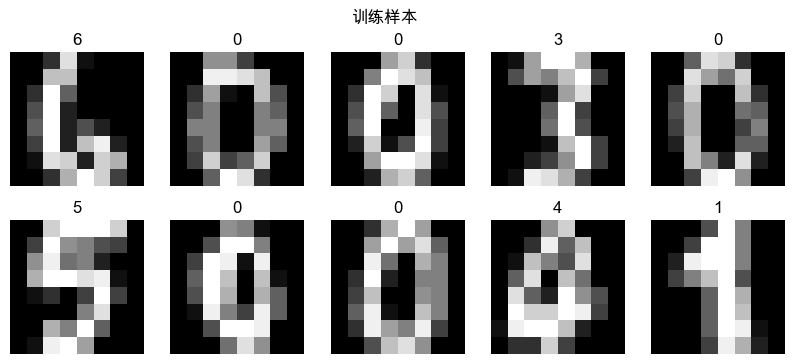

In [13]:
# ========================================
# 加载数据
# ========================================

digits = load_digits()
X = digits.data / 16.0
y = digits.target

X_train, X_test, y_train_idx, y_test_idx = train_test_split(X, y, test_size=0.2, random_state=42)

def one_hot(y, n=10):
    oh = np.zeros((len(y), n))
    oh[np.arange(len(y)), y] = 1
    return oh

y_train = one_hot(y_train_idx)
y_test = one_hot(y_test_idx)

print(f"训练集: {X_train.shape[0]}, 测试集: {X_test.shape[0]}")

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape(8, 8), cmap='gray')
    ax.set_title(f'{y_train_idx[i]}')
    ax.axis('off')
plt.suptitle('训练样本')
plt.show()

In [14]:
# ========================================
# 训练网络
# ========================================

print("="*50)
print("训练: BN + Dropout")
print("="*50)

np.random.seed(42)
model = ModernNeuralNetwork(use_bn=True, use_dropout=True)
history = train_network(model, X_train, y_train, X_test, y_test, epochs=100)

print(f"\n最终测试准确率: {history['test_acc'][-1]:.4f}")

训练: BN + Dropout
Epoch  20: Loss=0.1075, Train=0.9979, Test=0.9889
Epoch  40: Loss=0.0621, Train=0.9993, Test=0.9806
Epoch  60: Loss=0.0442, Train=1.0000, Test=0.9861
Epoch  80: Loss=0.0334, Train=1.0000, Test=0.9917
Epoch 100: Loss=0.0252, Train=1.0000, Test=0.9833

最终测试准确率: 0.9833


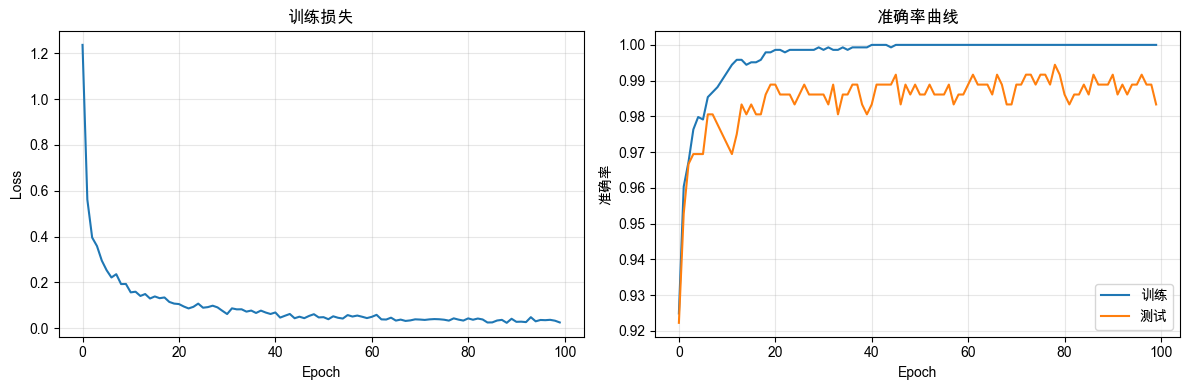

In [15]:
# ========================================
# 可视化训练过程
# ========================================

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['train_loss'])
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('训练损失')
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_acc'], label='训练')
axes[1].plot(history['test_acc'], label='测试')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('准确率')
axes[1].set_title('准确率曲线')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# ========================================
# 对比实验
# ========================================

configs = [
    {'name': '基础网络', 'use_bn': False, 'use_dropout': False},
    {'name': '仅BN', 'use_bn': True, 'use_dropout': False},
    {'name': '仅Dropout', 'use_bn': False, 'use_dropout': True},
    {'name': 'BN+Dropout', 'use_bn': True, 'use_dropout': True},
]

results = {}
for cfg in configs:
    print(f"\n{'='*40}")
    print(f"训练: {cfg['name']}")
    print('='*40)
    np.random.seed(42)
    model = ModernNeuralNetwork(use_bn=cfg['use_bn'], use_dropout=cfg['use_dropout'])
    results[cfg['name']] = train_network(model, X_train, y_train, X_test, y_test, epochs=100)


训练: 基础网络
Epoch  20: Loss=0.0441, Train=0.9958, Test=0.9667
Epoch  40: Loss=0.0134, Train=1.0000, Test=0.9778
Epoch  60: Loss=0.0057, Train=1.0000, Test=0.9778
Epoch  80: Loss=0.0038, Train=1.0000, Test=0.9778
Epoch 100: Loss=0.0026, Train=1.0000, Test=0.9778

训练: 仅BN
Epoch  20: Loss=0.0221, Train=1.0000, Test=0.9833
Epoch  40: Loss=0.0072, Train=1.0000, Test=0.9833
Epoch  60: Loss=0.0053, Train=1.0000, Test=0.9833
Epoch  80: Loss=0.0030, Train=1.0000, Test=0.9833
Epoch 100: Loss=0.0022, Train=1.0000, Test=0.9833

训练: 仅Dropout
Epoch  20: Loss=0.1295, Train=0.9889, Test=0.9750
Epoch  40: Loss=0.0641, Train=0.9972, Test=0.9778
Epoch  60: Loss=0.0375, Train=0.9993, Test=0.9778
Epoch  80: Loss=0.0266, Train=0.9993, Test=0.9806
Epoch 100: Loss=0.0225, Train=1.0000, Test=0.9806

训练: BN+Dropout
Epoch  20: Loss=0.1075, Train=0.9979, Test=0.9889
Epoch  40: Loss=0.0621, Train=0.9993, Test=0.9806
Epoch  60: Loss=0.0442, Train=1.0000, Test=0.9861
Epoch  80: Loss=0.0334, Train=1.0000, Test=0.9917
E

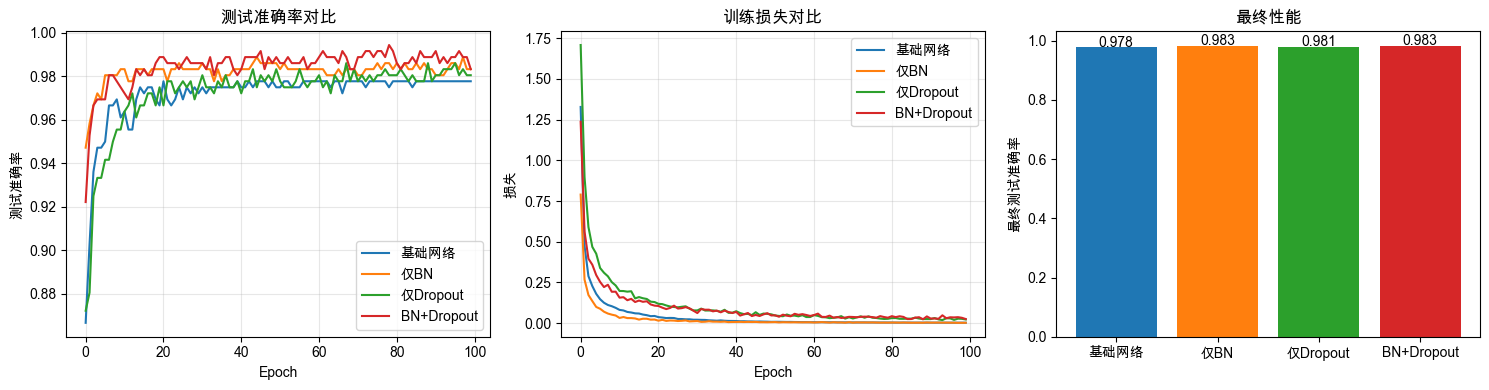


实验总结
基础网络        : 训练=1.0000, 测试=0.9778, 差距=0.0222
仅BN         : 训练=1.0000, 测试=0.9833, 差距=0.0167
仅Dropout    : 训练=1.0000, 测试=0.9806, 差距=0.0194
BN+Dropout  : 训练=1.0000, 测试=0.9833, 差距=0.0167


In [17]:
# ========================================
# 对比结果可视化
# ========================================

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for name, h in results.items():
    axes[0].plot(h['test_acc'], label=name)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('测试准确率')
axes[0].set_title('测试准确率对比')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for name, h in results.items():
    axes[1].plot(h['train_loss'], label=name)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('损失')
axes[1].set_title('训练损失对比')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

names = list(results.keys())
accs = [results[n]['test_acc'][-1] for n in names]
bars = axes[2].bar(names, accs, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[2].set_ylabel('最终测试准确率')
axes[2].set_title('最终性能')
for bar, acc in zip(bars, accs):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                 f'{acc:.3f}', ha='center')

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("实验总结")
print("="*50)
for name, h in results.items():
    gap = h['train_acc'][-1] - h['test_acc'][-1]
    print(f"{name:12s}: 训练={h['train_acc'][-1]:.4f}, 测试={h['test_acc'][-1]:.4f}, 差距={gap:.4f}")

---
# 第五部分：Layer Normalization

## BN vs LN

| 特性 | Batch Norm | Layer Norm |
|------|------------|------------|
| 标准化维度 | 跨样本 | 跨特征 |
| 依赖batch | 是 | 否 |
| 适用场景 | CNN | RNN/Transformer |

In [18]:
# ========================================
# Layer Normalization
# ========================================

class LayerNormalization:
    def __init__(self, n_features, epsilon=1e-5):
        self.gamma = np.ones(n_features)
        self.beta = np.zeros(n_features)
        self.epsilon = epsilon
        self.cache = None
    
    def forward(self, X, training=True):
        mean = np.mean(X, axis=1, keepdims=True)
        var = np.var(X, axis=1, keepdims=True)
        X_norm = (X - mean) / np.sqrt(var + self.epsilon)
        return self.gamma * X_norm + self.beta

# 对比
print("BN vs LN:")
X_test = np.random.randn(4, 6) * 3 + 5

bn = BatchNormalization(6)
ln = LayerNormalization(6)

bn_out = bn.forward(X_test, True)
ln_out = ln.forward(X_test, True)

print(f"BN后每个特征均值: {bn_out.mean(axis=0).round(4)}")
print(f"LN后每个样本均值: {ln_out.mean(axis=1).round(4)}")

BN vs LN:
BN后每个特征均值: [-0.  0. -0.  0.  0.  0.]
LN后每个样本均值: [-0. -0. -0. -0.]


---
# 第六部分：总结

## 6.1 本章核心概念回顾

### Batch Normalization
- **作用**：标准化每层输入，解决内部协变量偏移问题
- **效果**：加速收敛、允许更大学习率、有轻微正则化作用
- **关键**：训练时用 batch 统计，推理时用 running 统计

### Dropout
- **作用**：随机丢弃神经元，防止过拟合
- **效果**：强制网络学习冗余表示，提高泛化能力
- **关键**：训练时丢弃+缩放，推理时不操作（Inverted Dropout）

### Layer Normalization
- **作用**：对每个样本的所有特征标准化
- **适用**：RNN、Transformer 等序列模型
- **优势**：不依赖 batch size

## 6.2 技术对比

| 技术 | 解决问题 | 训练模式 | 推理模式 | 核心参数 |
|------|----------|----------|----------|----------|
| **BN** | 内部协变量偏移 | batch 均值/方差 | running 均值/方差 | momentum=0.9 |
| **Dropout** | 过拟合 | 随机mask + 缩放 | 直接输出 | p=0.3~0.5 |
| **LN** | 序列模型归一化 | 样本内统计 | 样本内统计 | epsilon=1e-5 |

### 训练 vs 推理模式

```python
# 训练时
output = model.forward(X, training=True)   # BN用batch统计，Dropout激活

# 推理时
output = model.forward(X, training=False)  # BN用running统计，Dropout关闭
```

## 6.3 超参数选择指南

### Dropout 率选择
| 层类型 | 推荐 Dropout 率 | 说明 |
|--------|-----------------|------|
| 全连接层 | 0.5 | 经典设置 |
| 卷积层 | 0.2 ~ 0.3 | 卷积层已有参数共享，不需要太强 |
| 输出层前 | 0.0 | 通常不在输出层前使用 |

### BN 参数选择
- **momentum**: 0.9（小数据集）或 0.99（大数据集）
- **epsilon**: 1e-5（默认值通常足够）

### 组件顺序
```
推荐：Dense → BN → ReLU → Dropout
替代：Dense → ReLU → BN → Dropout（效果略有差异）
```

## 6.4 常见问题排查

| 问题 | 可能原因 | 解决方案 |
|------|----------|----------|
| 训练损失不下降 | 学习率过大/过小 | 调整学习率，BN允许更大学习率 |
| 训练好但测试差 | 过拟合 | 增加 Dropout 率或数据增强 |
| 推理结果异常 | training 参数错误 | 确保推理时 `training=False` |
| BN 效果差 | batch size 太小 | 增大 batch size 或改用 LN |

## 6.5 实践建议

### 网络类型 → 推荐配置

| 网络类型 | 归一化 | Dropout | 说明 |
|----------|--------|---------|------|
| **CNN** | BN | 0.2~0.3 | 卷积后加 BN |
| **全连接** | BN | 0.5 | 本章实现的架构 |
| **RNN/LSTM** | LN | 0.2~0.5 | BN 不适合变长序列 |
| **Transformer** | LN | 0.1~0.3 | 标准配置 |

---

## 练习题

### 练习 1：探索 Dropout 率的影响
尝试 dropout_rate = [0.0, 0.1, 0.3, 0.5, 0.7]，观察：
- 训练准确率和测试准确率的差距（过拟合程度）
- 收敛速度的变化

**提示**：修改 `ModernNeuralNetwork(dropout_rate=?)` 即可

### 练习 2：BN 的位置实验
将 BN 放在 ReLU 之后：`Dense → ReLU → BN → Dropout`
对比与当前 `Dense → BN → ReLU → Dropout` 的效果

**提示**：修改 forward 中的执行顺序

### 练习 3：实现 Group Normalization
Group Norm 是 BN 和 LN 的折中：将通道分组后在组内标准化

**提示**：
```python
# 将特征 reshape 为 (batch, groups, features//groups)
# 在最后一个维度上计算均值和方差
```

### 练习 4：梯度检验
用数值微分验证 BN 的反向传播是否正确：

**提示**：
```python
def numerical_gradient(f, x, eps=1e-5):
    grad = np.zeros_like(x)
    for i in range(x.size):
        x_plus = x.copy(); x_plus.flat[i] += eps
        x_minus = x.copy(); x_minus.flat[i] -= eps
        grad.flat[i] = (f(x_plus) - f(x_minus)) / (2 * eps)
    return grad
```

---

## 下一章预告

**第8章：权重初始化**

我们将学习：
- 为什么全零初始化会失败？
- Xavier/Glorot 初始化（适合 tanh/sigmoid）
- He 初始化（适合 ReLU）
- 初始化与激活函数的匹配关系